# **ID2223: Scalable Machine Learning and Deep Learning**

### Lab 2 Show and Tell: A Neural Image Caption Generator

- Johan Mallo Bakken  \<johanmb@kth.se\>
- Vlado Mitrovic \<vladom@kth.se\>


In this lab assignment, we would like you to implement a code to automatically describe the content of an image by using CNNs and RNNs to build an Image Caption Generator as described in [*Show and Tell: A Neural Image Caption Generator*](https://arxiv.org/abs/1411.4555).


- Dataset : Flickr8k

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os, glob, pickle, string, random
import numpy as np
from PIL import Image, ImageFile
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf


START = "<start>"
STOP = "<stop>"
EPOCHS_1 = 20
EPOCHS_2 = 10


In [3]:
#Define the folder path to the data
path_to_data = "/content/drive/My Drive/flickr8k"

In [4]:
#Define the translation for punctuations in the text and define lookup dictionary.
null_punct = str.maketrans('', '', string.punctuation)
img_captions_lookup = defaultdict(list)

#Use the file holding the captions as fp.
with open( os.path.join(path_to_data,'Flickr8k_text', 'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  #We go through every line in the caption files.
  for line in fp.read().split('\n'):
    #We split the lines they consist of the filename and the caption
    w = line.split()
    if len(line) >= 2:
      #We assign the id and description to its variables
      id = w[0].split('.')[0]
      caption = w[1:]
      
      # Cleaning the description 
      # lowercase, remove punctuation, remove single charachter word and non alphabetical
      caption = [word.lower().translate(null_punct) for word in caption]
      caption = [word for word in caption if len(word)>1]
      caption = [word for word in caption if word.isalpha()]

      #Get length of the longest description
      max_length = max(max_length,len(caption))
      
      #Key: filename Value: list of descriptions
      img_captions_lookup[id].append(' '.join(caption))

#all_words is a set of all the words
all_words = set()
for key in img_captions_lookup:
  [all_words.update(d.split()) for d in img_captions_lookup[key]]

In [5]:
#Get all image paths
image_paths = glob.glob(os.path.join(path_to_data, 'Flicker8k_Dataset', '*.jpg'))

In [6]:
print(f'Number of caption keys : {len(img_captions_lookup)}')
print(f'Size of our vocabulary : {len(all_words)}')
print(f'Longest caption : {max_length}')
print(f'Number of images: {len(image_paths)}')

Number of caption keys : 8092
Size of our vocabulary : 8763
Longest caption : 32
Number of images: 8127


In [7]:
''' **** Not really good like this, some caption have no images
         and the saved encode is not coherent anymore

img_captions_lookup_keys = list(img_captions_lookup.keys())
random.shuffle(img_captions_lookup_keys)
slice_index = int(len(img_captions_lookup_keys)*0.8)

train_images = [s + '.jpg' for s in img_captions_lookup_keys[:slice_index]]
test_images = [s + '.jpg' for s in img_captions_lookup_keys[slice_index:]]
'''

#Get the filenames for the train images and put them in set
train_images_path = os.path.join(path_to_data, 'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))

#Get the filenames for the test images and put them in a set
test_images_path = os.path.join(path_to_data, 'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

#Get the image filenames and put them in the lists
train_img = []
test_img = []

for i in image_paths:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [8]:
print(f'Number train images : {len(train_img)}')
print(f'Number test images  : {len(test_img)}')

Number train images : 6000
Number test images  : 1000


In [9]:
#We go through the key and values in the lookup we check if the image key has a 
#corresponding filename in the train_images list, if not its left out.
train_descriptions = {k:v for k,v in img_captions_lookup.items() if f'{k}.jpg' \
                      in train_images}

#Go though all the captions and add a start and stop token on them
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [10]:
#We define our model using InceptionV3 with the imagenet weights.
img_model = tf.keras.applications.InceptionV3(weights='imagenet')

#We remove the dense layer at the end of InceptionV3
img_model = tf.keras.models.Model(img_model.input, img_model.layers[-2].output)

#We define the width and the height of the images to fit the model
IMG_WIDTH = 299
IMG_HEIGHT = 299
#With normal inception v3 we would get 1000 probabilities from the last vector
#since there are 1000 images in image net. Each of this would give the probability 
#that the image is one of those. But we stripped that layer off and below we have
#a densely connected layer. We use those outputs, these become "engineered"
#features for the images.  
IMG_OUTPUT_DIM = 2048

96116736/96112376 [==============================] - 1s 0us/step


In [11]:
#encode_model.summary()

In [12]:
def encodeImage(img):
  # Resize all images to 299 x 299 so they fit in the CNN
  img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
  # Convert the PIL image to a numpy array (adds three dimensions)
  x = tf.keras.preprocessing.image.img_to_array(img)
  # Expands the array to be a 2D array by adding a dimension
  x = np.expand_dims(x, axis=0)
  # Perform the preprocessing needed by InceptionV3, we normalize the values to be between -1 and 1
  x = tf.keras.applications.inception_v3.preprocess_input(x)
  # We make the prediction of the image InceptionV3 
  x = img_model.predict(x) 
  # We strip of one dimension
  x = np.reshape(x, IMG_OUTPUT_DIM )
  return x

In [13]:
def encodeData(data, dataset_name):
  path = os.path.join(path_to_data,"data",f'{dataset_name}{IMG_OUTPUT_DIM}.pkl')

  if not os.path.exists(path):
    encoded_images = {}
    for filename in tqdm(data):
      image_path = os.path.join(path_to_data,'Flicker8k_Dataset', filename)
      # We load the desired image
      img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
      # We call the encoding function and save the output vectors.
      encoded_images[filename] = encodeImage(img)
    # Pickle all the output vectors in a file
    with open(path, "wb") as fp:
      pickle.dump(encoded_images, fp)
      return encoded_images
  else:
    with open(path, "rb") as fp:
      return pickle.load(fp)


In [14]:
encoded_training_images = encodeData(train_img, 'train')

encoded_test_images = encodeData(test_img, 'test')

In [15]:
all_train_captions = []
#Go through all the train captions and add them to a list
for val in train_descriptions.values():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [16]:
#Find the word counts
word_count_threshold = 10
word_counts = defaultdict(int)
for sent in all_train_captions:
    for w in sent.split(' '):
        word_counts[w] += 1

#Limit the vocabulary to the words with more than word_count_threshold occurances
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [17]:
#Make dictionaries to map from index to word and word to index
idxtoword = {}
wordtoidx = {}

for i in range(len(vocab)):
  w, idx = vocab[i], i+1
  wordtoidx[w] = idx
  idxtoword[idx] = w

# TODO: WHY + 1    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [18]:

#TODO: +2 BECAUSE OF START/STOP
max_length += 2
print(max_length)

34


In [19]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x_images - Training data for photos
  # x_caption - The caption that goes with each photo
  # y_rest_caption - The predicted rest of the caption
  x_images, x_caption, y_rest_caption = [], [], []
  count=0
  while True:
    #Go though all the descriptions/captions
    for key, desc_list in descriptions.items():
      count+=1
      photo = photos[key+'.jpg']
      # For each photo, we loop trough all the captions
      for desc in desc_list:
        # Convert each word into a list of sequences using our dictonary
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          # Separate the sequence with the input for the prediction and the correct output
          in_seq, out_seq = seq[:i], seq[i]
          # Pad to have a same size for all caption, this is set to the max size
          in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
          # We transform the value to a categorical format, similar to "OneHotEncoder" 2 -> [0, 0, 1, 0 0 0 0]
          out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]

          # We add our data in the learning dataset arrays
          x_images.append(photo)
          x_caption.append(in_seq)
          y_rest_caption.append(out_seq)

      # We limit the data set to the size of the batch defined in the learning function
      if count==num_photos_per_batch:
        yield ([np.array(x_images), np.array(x_caption)], np.array(y_rest_caption))
        x_images, x_caption, y_rest_caption = [], [], []
        count=0

In [20]:
glove_dir = os.path.join(path_to_data,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

#Read GloVe file
for line in tqdm(f):
  values = line.split()
  #Retrieve the word
  word = values[0]
  #Retrive the coeficcients, 
  coefs = np.asarray(values[1:], dtype='float32')
  #Add to dictionary
  embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:32, 12345.13it/s]

Found 400000 word vectors.


In [21]:
embedding_dim = 200

# We define a matrix where we can add the word embeddings for each of the
# words in our vocabulary.
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # If the word has an embedding vector the values are added to the matrix
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_matrix.shape

(1652, 200)

In [23]:
#We define the input layers for the image and the caption
inputs1 = tf.keras.Input(shape=(IMG_OUTPUT_DIM,), name='Image_input')
inputs2 = tf.keras.Input(shape=(max_length,), name='Caption_input')

#The layers for the image
fe1 = tf.keras.layers.Dropout(0.5, name="Image_dropout")(inputs1)
fe2 = tf.keras.layers.Dense(256, activation='relu', name="Image_dense")(fe1)

#The layers for the caption
se1 = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, name="Word_embedding")(inputs2)
se2 = tf.keras.layers.Dropout(0.5, name="Caption_dropout")(se1)
se3 = tf.keras.layers.LSTM(256, name="Caption_LSTM")(se2)

#Common decoder layers
decoder1 = tf.keras.layers.add([fe2, se3], name="Decode_sum_inputs")
decoder2 = tf.keras.layers.Dense(256, activation='relu', name="Decode_dense")(decoder1)
outputs = tf.keras.layers.Dense(vocab_size, activation='softmax', name="Output_vocab_size")(decoder2)

#Making the final model difining the input and output layers
caption_model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

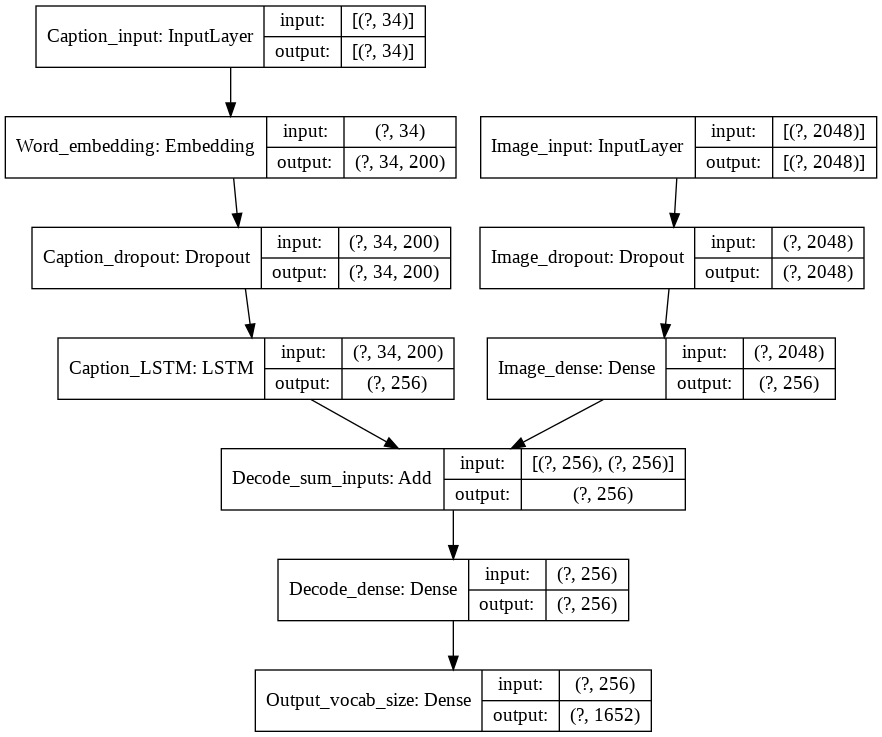

In [24]:
tf.keras.utils.plot_model(caption_model, show_shapes=True, show_layer_names=True)

In [25]:
embedding_dim

200

In [26]:
caption_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Caption_input (InputLayer)      [(None, 34)]         0                                            
__________________________________________________________________________________________________
Image_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
Word_embedding (Embedding)      (None, 34, 200)      330400      Caption_input[0][0]              
__________________________________________________________________________________________________
Image_dropout (Dropout)         (None, 2048)         0           Image_input[0][0]                
_______________________________________________________________________________________

In [27]:
# We set the weights of our embedding layer with our embedding matrix defined before

caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [28]:
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [29]:
# Show the chart with the lost function
def showChart(hist, name):
    plt.plot(hist.history['loss'])
    plt.title(f'model loss: {name}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.savefig(os.path.join(path_to_data,"data",f'model_loss_{name}.png'))

In [30]:
model_path = os.path.join(path_to_data,"data",f'caption-model.hdf5')

# Load our weights or train the model if no weight available
if not os.path.exists(model_path):

  # tqdm is used to have a nice progress bar
  # we train our model 20 times with a batch size of 3 
  # we use the generator function defined before 


  generator = data_generator(train_descriptions, encoded_training_images, 
                wordtoidx, max_length, number_pics_per_batch)
  
  # we train our model with fir generetor 
  hist = caption_model.fit_generator(generator, epochs=EPOCHS_1, steps_per_epoch=steps, verbose=1)

  showChart(hist, 'First')

  # we reduce the learning rate and increase the batch size

  caption_model.optimizer.lr = 1e-4
  number_pics_per_batch = 6
  steps = len(train_descriptions)//number_pics_per_batch

  # We train our model with different hyperparameters
  generator = data_generator(train_descriptions, encoded_training_images, 
                wordtoidx, max_length, number_pics_per_batch)
  hist2 = caption_model.fit_generator(generator, epochs=EPOCHS_2, steps_per_epoch=steps, verbose=1) 

  showChart(hist2, 'Second')

  # Finally we save the model as this step can take a while
  caption_model.save_weights(model_path)
else:
  caption_model.load_weights(model_path)

Plot of the model loss for each training.

Took about 2 hours on the local machine.

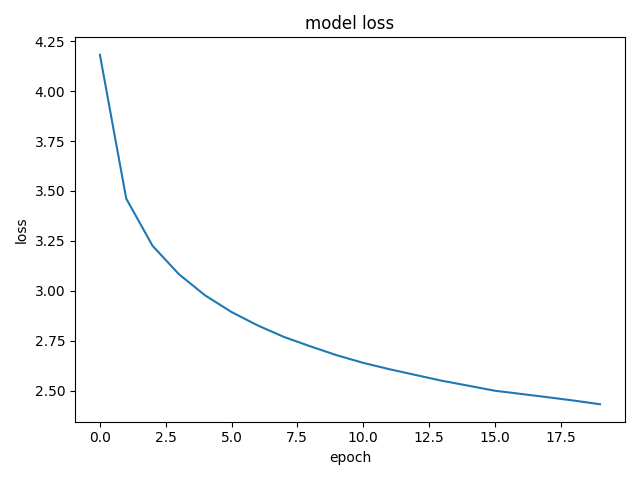

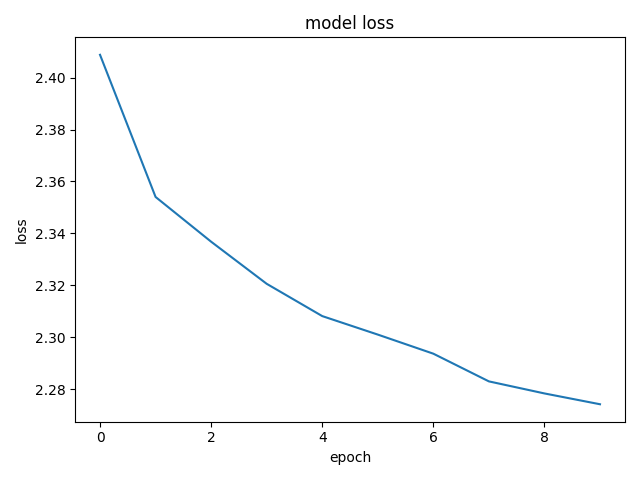

In [33]:
# We define this function to call our model

def generateCaption(photo):

    # Input text, we start with the start token
    in_text = START

    # We loop for a maximum of the longest caption
    for i in range(max_length):

        # Convert each word into a list of sequences using our dictonary
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]

        # Pad the sequence with the max lenght
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)

        # Prediction of word, return a vector with the size of our vocabulary and probability for each word
        yhat = caption_model.predict([photo,sequence], verbose=0)

        # We select the highest probability
        yhat = np.argmax(yhat)

        # Convert the index to the string
        word = idxtoword[yhat]

        # Append the predicted word to our caption
        in_text += ' ' + word

        # We stop the prediction once the stop token is predicted
        if word == STOP:
            break

    # Finally we remove the start and end token
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

/content/drive/My Drive/flickr8k/Flicker8k_Dataset/3406930103_4db7b4dde0.jpg


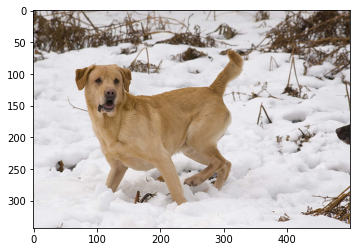

Caption: brown dog is running through the snow
_____________________________________
/content/drive/My Drive/flickr8k/Flicker8k_Dataset/3375070563_3c290a7991.jpg


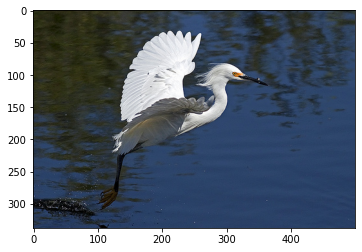

Caption: white bird is flying over water
_____________________________________


In [45]:
# Generating caption for some images

for i in range(2):
  pic = list(encoded_test_images.keys())[i]

  # Reshape the image according to the model dimention
  image = encoded_test_images[pic].reshape((1,IMG_OUTPUT_DIM))
  print(os.path.join(path_to_data,'Flicker8k_Dataset', pic))

  # Show the image and print the predicted caption
  x=plt.imread(os.path.join(path_to_data,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [35]:
encoding_test[pic].shape

(2048,)

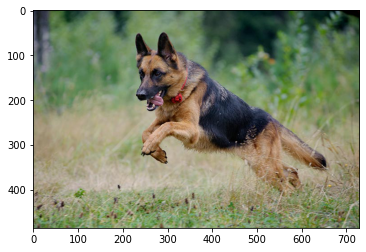

(1, 2048)
Caption: dog runs through field
_____________________________________


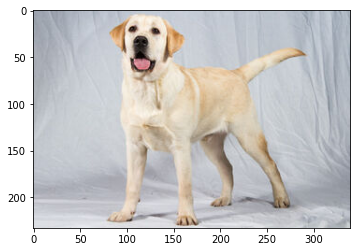

(1, 2048)
Caption: dog is running through the water
_____________________________________


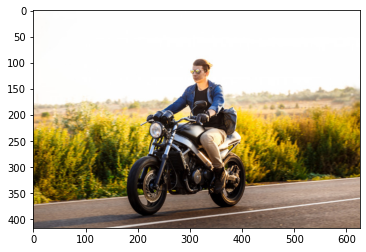

(1, 2048)
Caption: man in helmet riding dirt bike
_____________________________________


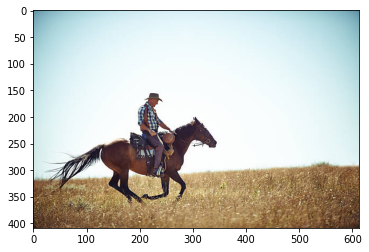

(1, 2048)
Caption: woman in blue cowboy hat and riding on horse
_____________________________________


In [46]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

urls = [
        "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/22170353/German-Shepherd-Dog-running.jpg",
        "https://static.wikia.nocookie.net/parody/images/2/22/Dog.jpg/revision/latest/scale-to-width-down/340?cb=20140906225011",
        "https://image.freepik.com/free-photo/young-handsome-man-riding-motorbike-countryside-road_176420-2565.jpg",
        "https://media.istockphoto.com/photos/freedom-on-the-open-fields-picture-id494237129?k=6&m=494237129&s=612x612&w=0&h=m34ELr7StqDcSRG39ELyF8I_bjbV9ju1tb-ZqQ2im2M="
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,IMG_OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")

We can see that our model are not perfect, but the captions are still coherent and related.

References :

This code is based on the lecture of **Jeff Heaton**, professor at McKelvey School of Engineering, Washington University in St. Louis, USA. More information about his courses on this [link](https://sites.wustl.edu/jeffheaton/t81-558/).